In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans 
from filterpy.kalman import KalmanFilter
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

## Question 10

In [3]:
img = cv2.imread('Question_10/books.png')
## for Canny
threshold1 = 100
threshold2 = 200
## for HoughLines
rho = 1
theta = 0.0017
threshold = 200

def Houghlines(img,canny_threshold1,threshold2,rho,theta,threshold):
        # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray, canny_threshold1, threshold2)
    # Apply HoughLines
    lines = cv2.HoughLines(edges, rho, theta, threshold)
    # Print number of lines detected
    print(f"Number of lines detected: {len(lines)}")
    
Houghlines(img,threshold1,threshold2,rho,theta,threshold)

Number of lines detected: 32


## Question 11

In [4]:
img = cv2.imread('Question_11/books.png')
# for Harris
blockSize=2
ksize=3
k=0.04 
above = 0.01

def Harriscorner(img,blockSize, ksize, k, above):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply Harris corner
    corners = cv2.cornerHarris(gray, blockSize, ksize, k)
    # Find number of values above 0.01
    num_values = corners[corners > above].size
    print(f"Number of values above {above}: {num_values}")
    
Harriscorner(img,blockSize,ksize,k,above)

Number of values above 0.01: 188


## Question 12

In [5]:
# Parameters
img1 = cv2.imread('Question_12/things1.png')
img2 = cv2.imread('Question_12/things2.png')
# for goodFeaturesToTrack
maxCorners = 100
qualityLevel = 0.3
minDistance = 7

def GoodFeatures(img1,img2,maxCorners,qualityLevel,minDistance):
    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Use cv2.goodFeaturesToTrack 
    points_1 = cv2.goodFeaturesToTrack(gray1, maxCorners, qualityLevel, minDistance)

    # Apply sparse optical flow 
    points_2, _, _ = cv2.calcOpticalFlowPyrLK(gray1, gray2, points_1, None)

    # Find the maximum amount of pixels moved for any object in the x direction (horizontally)
    max_x = np.abs(points_1[:,:,0]-points_2[:,:,0]).max()
    print(f"Maximum amount of pixels moved for any object in the x direction (horizontally): {max_x}")


GoodFeatures(img1,img2,maxCorners,qualityLevel,minDistance)

Maximum amount of pixels moved for any object in the x direction (horizontally): 15.6368408203125


## Question 18

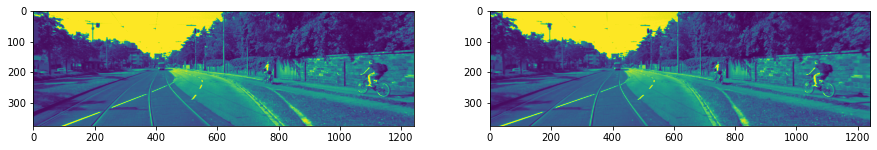

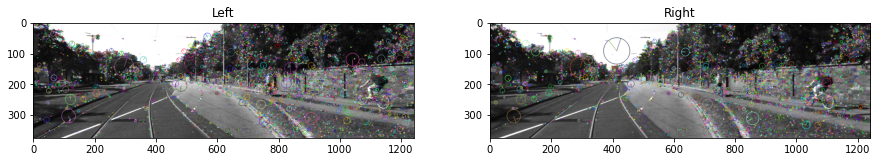

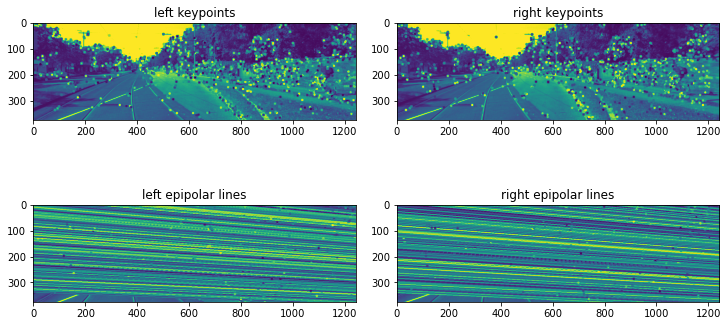

In [6]:
# Q18

##########################   NEW CODE       ###########################################

img1 = cv2.imread('Question_18/left.png', 0)
img2 = cv2.imread('Question_18/right.png', 0)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs[0].imshow(img1)
axs[1].imshow(img2);
img1.shape

# Create a sift detector
sift = cv2.xfeatures2d.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img_1 = cv2.drawKeypoints(img1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_img_2 = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].imshow(kp_img_1)
ax[0].set_title('Left')
ax[1].imshow(kp_img_2)
ax[1].set_title('Right');
bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
# 2000 best matches                      #CHANGE HERE
matches = sorted(matches, key = lambda x:x.distance)[:2000]  #change here

# From exercise 2 week 4
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1, img2
# Extract points of matches
pts1 = []
pts2 = []

# Using 2000 best matches
for m in matches:
    # Extract points corresponding to matches.
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    
"""
Implement findFundamentalMat here:
"""
F, mask =cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

# We select only inlier points.
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1.copy(), img2.copy(), lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2.copy(), img1.copy(), lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,5))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()

In [7]:
w, h = lines1.shape
######### THE AVERAGE OF ALL EPILINES #########
print(sum(lines1)/w)
avg1 = sum(lines1)/w
print(sum(lines2)/w)
avg2 = sum(lines2)/w

[-6.69333264e-02  9.97691572e-01 -1.26727486e+02]
[ 7.0291542e-02 -9.9747336e-01  1.2541019e+02]


## Question 19

In [22]:
p = 0.98 #probability of ransac choosing a set without outliers
w = 0.75 #proportion of inliers with respect to all the points in the dataset
# Formula from the question:
k = (np.log(1-p))/(np.log(1-w**2))
print(k)

4.732217735314645


In [23]:
# Question 19.2
# Parameters
p = 0.98      #change here
w = 0.75

def num_iterations(p, w):
    # Round number of iterations to the nearest integer(up)
    n_iter = np.ceil(np.log(1-p)/np.log(1-w**2))
    return n_iter

print(f"Number of iterations: {num_iterations(p, w)}")

Number of iterations: 5.0


## Question 23
### Question 23.1

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

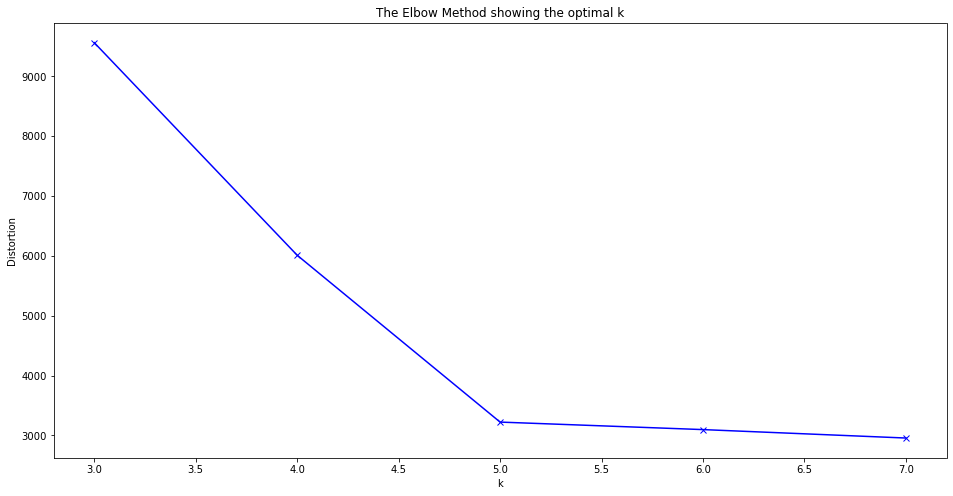

In [28]:
'''
- Use the elbow method to find how many clusters are optimal for this dataset.
- Plot will be saved instead of shown on screen.
'''

from sklearn.cluster import KMeans 
import numpy as np
import matplotlib.pyplot as plt

# Parameters
K_option = [3,4,5,6,7]   # change here

# Loading the data
X = np.loadtxt('Question_23/clusters.txt', dtype=int)

distortions = []
for k in K_option:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    # save score
    score = kmeans.score(X)
    distortions.append(kmeans.inertia_)

# Elbow method
# k nums which are shown after the steep curve are the solutions
plt.figure(figsize=(16,8))
plt.plot(K_option, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
#plt.savefig('./data/k_means_and_pca/elbow.png')

### Question 23.2

In [43]:
'''
Perform PCA on the provided dataset and determine the minimum number of
components required to express 95% of the variance.
'''
import numpy as np
from sklearn.decomposition import PCA

# Parameters
data_path = 'Question_23/clusters.txt'
pct_variance = 0.95                               #change here

# Load data
X = np.loadtxt(data_path, dtype=int)

# Perform PCA
pca = PCA(n_components=None)
pca.fit(X)

# print components variance
pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance: {pca_cumsum}")

# Find number of components required to express 95% of the variance
num_components = np.argmax(pca_cumsum >= pct_variance) + 1
print(f"Number of components needed to explain {pct_variance} of data: {num_components}")


Variance: [0.39540225 0.67312775 0.83557005 0.91588029 0.93656342 0.95479334
 0.97030283 0.98210965 0.99213048 1.        ]
Number of components needed to explain 0.95 of data: 6


## Question 23.3

In [59]:
# Parameters
data_path = 'Question_23/clusters.txt'
pct_variance = 0.95
K_options = [5,6] # (SUB-QUESTION A)           # change here based on 1 and 2

# Load data
X = np.loadtxt(data_path, dtype=int)

# Perform PCA
pca = PCA(n_components=None)
pca.fit(X)

pca_cumsum = np.cumsum(pca.explained_variance_ratio_)

# Find number of components required to express 95% of the variance
num_components = np.argmax(pca_cumsum >= pct_variance)

# Trim number of components
X_trim = pca.transform(X)[:, :num_components]

# K means
for K in K_options:
    # Perform K-means
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(X_trim)
    # Calculate the Inertia (sumof squared differences of samples to the closest centroid)
    inertia = kmeans.inertia_
    print(f"Inertia for K={K}: {inertia}")

Inertia for K=5: 1779.6870825612284
Inertia for K=6: 1666.385560117632


## Question 24

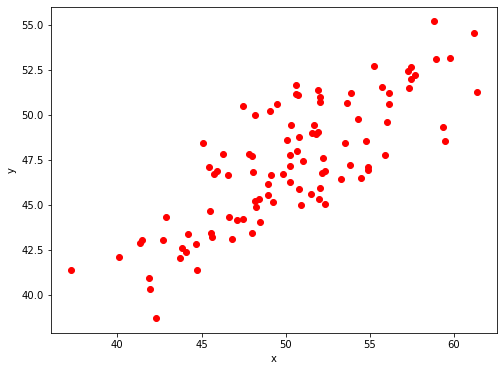

In [61]:
# Linear regression
# Given the dataset x, y apply linear regression to find the model of the form: y = ax + b

# What are the values of "a" and "b" in that model?

# Recall: 
# ```{Python}
# x_reshaped = x.reshape(-1, 1) #fit needs data in this shape
# # Initialize and fit model
# lm = LinearRegression()
# model = lm.fit(input, target)
# ```


x = np.loadtxt('Question_24/lr_x.txt', dtype=float)
y = np.loadtxt('Question_24/lr_y.txt', dtype=float)
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'ro')   # scatter plot showing actual data
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [62]:
x_reshaped = x.reshape(-1, 1) #fit needs data in this shape
# Initialize and fit model
lm = LinearRegression()
model = lm.fit(x_reshaped, y)

print("a",lm.coef_)
print("b",lm.intercept_)

a [0.54587938]
b 19.856337311955023


## Question 27

In [39]:
# Parameters
state_dim = 4

state = np.array([[3],   # x                            #change here
                [0.5],   # velocity x
                [2],     # y
                [0.33]]) # velocity y
covariance = np.array([[5, 1, 0, 0],                          #change here
                        [1, 2, 0, 0],
                        [0, 0, 5, 1],
                        [0, 0, 1, 2]])
delta_t = 1                                               #change here incase
state_transition_matrix = np.array([[1, delta_t, 0, 0],
                                    [0, 1, 0, 0],
                                    [0, 0, 1, delta_t],
                                    [0, 0, 0, 1]])
noise = np.zeros((state_dim, state_dim))

# Create kalman filter
kalman = KalmanFilter (dim_x=state_dim, dim_z=2)

# initialize
kalman.x = state

# state trasition matrix - is it correct?
kalman.F = state_transition_matrix

# Noise
kalman.Q = noise

# covariance matrix
kalman.P = covariance

kalman.predict()
print(f"state\n{kalman.x}\n\ncovariance\n{kalman.P}")

state
[[3.5 ]
 [0.5 ]
 [2.33]
 [0.33]]

covariance
[[9. 3. 0. 0.]
 [3. 2. 0. 0.]
 [0. 0. 9. 3.]
 [0. 0. 3. 2.]]


## Question 28

In [40]:
# Parameters
state_dim = 4

state = np.array([[5],   # x                       #change here
                [0.5],   # velocity x
                [7],     # y
                [0.8]])  # velocity y

measurement = np.array([[4.8],[7.1]]) # x , y            #change here
meas_dim = len(measurement)
covariance = np.array([[0.2, 0.0, 0.0, 0.0],            #change here
                        [0.2, 0.1, 0.0, 0.0],
                        [0.0, 0.0, 0.2, 0.0],
                        [0.0, 0.0, 0.2, 0.1]])
delta_t = 1                                           #could use same or could be changed
state_transition_matrix = np.array([[1, delta_t, 0, 0],
                                    [0, 1, 0, 0],
                                    [0, 0, 1, delta_t],
                                    [0, 0, 0, 1]])

noise = np.zeros((state_dim, state_dim))           #change here
R = np.array([[0.2, 0.2],
                [0.2, 0.2]])

measurement_f = np.array([[1, 0, 0, 0], # x
                        [0, 0, 1, 0]])  # y

# Create kalman filter
kalman = KalmanFilter (dim_x=state_dim, dim_z=meas_dim)

# initialize
kalman.x = state

# state trasition matrix - is it correct?
kalman.F = state_transition_matrix

# oise
kalman.Q = noise

# measurement function
kalman.H = measurement_f

# covariance matrix
kalman.P = covariance

kalman.R = R
kalman.update(measurement)
print(f"state\n {kalman.x }\n\ncovariance\n{kalman.P}")

state
 [[4.83333333]
 [0.33333333]
 [7.13333333]
 [0.93333333]]

covariance
[[ 6.66666667e-02 -1.38777878e-17  6.66666667e-02  6.93889390e-18]
 [ 6.66666667e-02  1.00000000e-01  6.66666667e-02  6.93889390e-18]
 [ 6.66666667e-02  6.93889390e-18  6.66666667e-02 -6.93889390e-18]
 [ 6.66666667e-02  6.93889390e-18  6.66666667e-02  1.00000000e-01]]


## Question 29

In [41]:
#Question 29.1 +29.2
# Parameters
data_path_x = 'Question_29/svm_x.txt'
data_path_y = 'Question_29/svm_y.txt'

# Load data
x = np.loadtxt(data_path_x, dtype=float)
y = np.loadtxt(data_path_y, dtype=int)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1337) #change here 30% for testing and 70% for training
print(f"Proportion used for training: {len(X_train)*100/len(x):.1f}%")

# Apply SVM with Linear Kernel
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.2f}")

Proportion used for training: 69.9%
Accuracy: 0.96


## Question 32

In [42]:
# Params
MATCH_NUM = 400        #these numbers could be changed #check image number in path
IMG_PATH = 'Question_32'
K = np.array([[7.188560e+02, 0.000000e+00, 6.071928e+02], [0, 7.188560e+02, 1.852157e+02], [0, 0, 1]]) #change here
BASELINE = 0.54                              #change here
SHOW_IMG = True
# Specify img range(check dir)
IMG_START = 400                  #check image number in path
IMG_END = 451                       #check image number in path+1

def extract_keypoints_surf(img1, img2, K, baseline):
    """
    use surf to detect keypoint features
    remember to include a Lowes ratio test
    """
    surf = cv2.SIFT_create()
    kp1, des1 = surf.detectAndCompute(img1,None)
    kp2, des2 = surf.detectAndCompute(img2,None)
    
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    knn_matches = matcher.knnMatch(des1, des2, 2)
    
    
    # Filter matches using the Lowe's ratio test
    ratio_thresh = 0.7
    good_matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
            
    good_matches = sorted(good_matches, key = lambda x:x.distance)
    good_matches = good_matches[:MATCH_NUM]
    
    matchesTrainIdx = [x.trainIdx  for x in good_matches]
    matchesQueryIdx = [x.queryIdx  for x in good_matches]
   
    match_points1 = [kp1[i].pt for i in matchesQueryIdx]
    match_points2 = [kp2[i].pt for i in matchesTrainIdx]
    
    p1 = np.float32(np.array(match_points1))
    p2 = np.float32(np.array(match_points2))

    #project the feature points to 3D with triangulation
    
    M_left = K.dot(np.hstack((np.eye(3), np.zeros((3, 1)))))
    M_rght = K.dot(np.hstack((np.eye(3), np.array([[-baseline, 0, 0]]).T)))

    p1_flip = np.vstack((p1.T, np.ones((1, p1.shape[0]))))
    p2_flip = np.vstack((p2.T, np.ones((1, p2.shape[0]))))

    P = cv2.triangulatePoints(M_left, M_rght, p1_flip[:2], p2_flip[:2])

    # Normalize homogeneous coordinates (P->Nx4  [N,4] is the normalizer/scale)
    P = P / P[3]
    land_points = P[:3]

    return land_points.T, p1

def featureTracking(prev_img, next_img, prev_points, world_points):
    """
    Use OpenCV to find the prev_points from the prev_img in the next_img
    Remember to remove points that could not be found from prev_points, next_points, and world_points
    """
    params = dict(winSize=(21, 21),
                 maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, next_img, prev_points, nextPts=None, \
                                                      winSize=params["winSize"], maxLevel=params["maxLevel"], criteria=params["criteria"])
    
    next_points = np.squeeze(next_points[np.where(status[:,0]==1),:])
    prev_points = np.squeeze(prev_points[np.where(status[:,0]==1),:])
    world_points = np.squeeze(world_points[np.where(status[:,0]==1),:])
    
    return world_points, prev_points, next_points

def get_image(path, index):
    return cv2.imread(f'{path}/{index:010d}.png')

if __name__ == '__main__':
    left_img = get_image(f"{IMG_PATH}/left", IMG_START)
    right_img = get_image(f"{IMG_PATH}/right", IMG_START)

    # Get 3D points Using Triangulation
    landmark_3D, reference_2D = extract_keypoints_surf(left_img, right_img, K, BASELINE)
    
    # reference
    prev_img = left_img
    traj = np.zeros((left_img.shape[0]//2, 300, 3), dtype=np.uint8)
    for i in range(IMG_START, IMG_END):
        curImage = get_image(f"{IMG_PATH}/left", i)
        curImage_R = get_image(f"{IMG_PATH}/right", i)

        # the 2D landmarks at the current time = t
        landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(prev_img, 
                                                                      curImage, 
                                                                      reference_2D,
                                                                      landmark_3D)

        #Calculate relative pose using PNP
        _, rvec, tvec, _ = cv2.solvePnPRansac(landmark_3D,tracked_2Dpoints,K, None)
    
        rot, _ = cv2.Rodrigues(rvec)
        tvec = -rot.T.dot(tvec)  # coordinate transformation, from camera to world. What is the XYZ of the camera wrt World
        inv_transform = np.hstack((rot.T, tvec))  # inverse transform. A tranform projecting points from the camera frame to the world frame

        # re-obtain the 3D points
        landmark_3D_new, reference_2D_new = extract_keypoints_surf(curImage, curImage_R, K, BASELINE)
        
        #Project the points from camera to world coordinates
        reference_2D = reference_2D_new.astype('float32')
        landmark_3D = inv_transform.dot(np.vstack((landmark_3D_new.T, np.ones((1, landmark_3D_new.shape[0])))))
        landmark_3D = landmark_3D.T

        prev_img = curImage

        # draw images
        draw_x, draw_y = int(tvec[0]) + 150, (left_img.shape[0]//2)-(int(tvec[2]) + 50);

        print(f"\nImage: {i}\nPosition: {tvec.squeeze()}\nRotation: {rvec.squeeze()}")
        
        if SHOW_IMG:
            text = "Coordinates:\n x ={0:02f}m\n y = {1:02f}m\n z = {2:02f}m".format(float(tvec[0]), float(tvec[1]),
                                                                            float(tvec[2]))
            text = text.split('\n')
            text_frame = np.zeros((left_img.shape[0]//2, 300, 3), dtype=np.uint8);
            cv2.circle(traj, (draw_x, draw_y), 1, (0, 0, 255), 2)
            cv2.putText(text_frame, text[0], (10, 30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, 8)
            cv2.putText(text_frame, text[1], (10, 60), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, 8)
            cv2.putText(text_frame, text[2], (10, 90), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, 8)
            cv2.putText(text_frame, text[3], (10, 120), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, 8)
            
            vis = np.vstack((text_frame, traj))
            vis = np.hstack((curImage, vis))
            
            cv2.imshow("Trajectory", vis)
            k = cv2.waitKey(1) & 0xFF
            if k == 27: break
    print(f"\n\n======= Results ======= \nPosition: {tvec.squeeze()}\nRotation: {rvec.squeeze()}")
    cv2.destroyAllWindows()


Image: 400
Position: [-0.00072985 -0.00364253  0.00034188]
Rotation: [ 3.13788240e-05 -4.32780996e-05  1.96405957e-04]

Image: 401
Position: [-0.01370059 -0.01901545  0.6270705 ]
Rotation: [0.00312403 0.00035855 0.00196335]

Image: 402
Position: [-0.02278272 -0.03009975  1.22437236]
Rotation: [ 5.94245441e-03  2.68480950e-03 -8.32436066e-05]

Image: 403
Position: [-0.02342759 -0.04395513  1.79614192]
Rotation: [ 0.00559525  0.00754156 -0.00602846]

Image: 404
Position: [-0.0329419  -0.06095483  2.34405999]
Rotation: [ 0.00377893  0.01544929 -0.00952331]

Image: 405
Position: [-0.04882564 -0.07445912  2.87757669]
Rotation: [ 0.00016763  0.02632969 -0.01177106]

Image: 406
Position: [-0.08646716 -0.08614268  3.39877096]
Rotation: [-0.00327879  0.04024153 -0.01203125]

Image: 407
Position: [-0.13221765 -0.09975845  3.90241067]
Rotation: [-0.00535514  0.0589964  -0.01207969]

Image: 408
Position: [-0.18689078 -0.11124078  4.40699376]
Rotation: [-0.00401048  0.08085226 -0.01523439]

Image: